# Classifiers - low vs high complexity - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution()
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with standard scaler
phase_all_train = scale(phase_all_train, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with standard scaler
phase_all_valid = scale(phase_all_valid, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 256
epochs = 2000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='sigmoid', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='linear', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

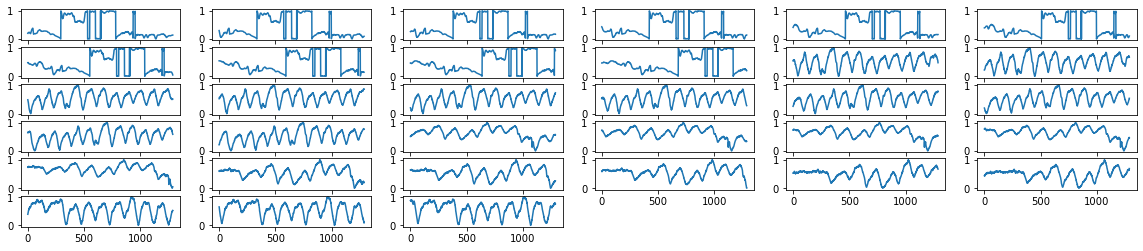

<Figure size 432x288 with 0 Axes>

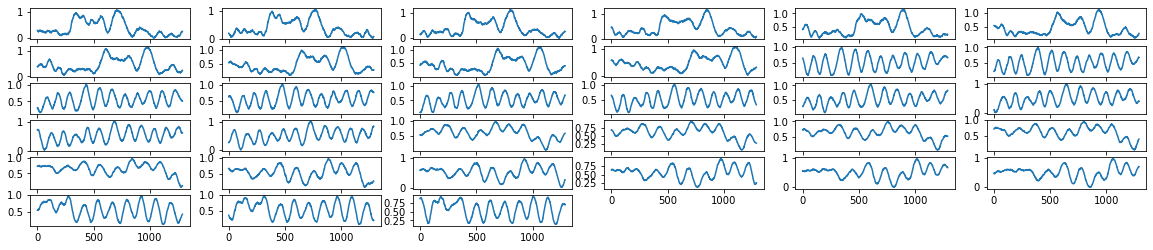

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

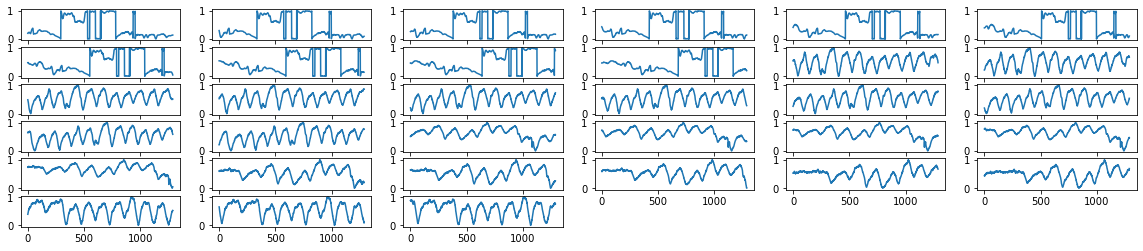

<Figure size 432x288 with 0 Axes>

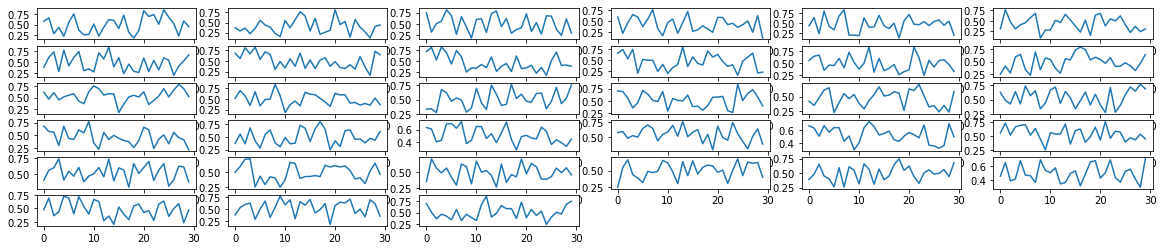

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [23]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:

                    # scale phase in a different way than other features
                    if (index == 1): 
                        # Scale each row with standard scaler
                        train_x = scale(train_x, axis=1)
                        valid_x = scale(valid_x, axis=1)
                        test_x = scale(test_x, axis=1)
                        # Scale each row with MinMax to range [0,1]
                        train_x = MinMaxScaler().fit_transform(train_x.T).T
                        valid_x = MinMaxScaler().fit_transform(valid_x.T).T
                        test_x = MinMaxScaler().fit_transform(test_x.T).T
                    else:
                        # Scale with standard scaler
                        sscaler = StandardScaler()
                        sscaler.fit(train_x)
                        train_x = sscaler.transform(train_x)

                        # Scale with MinMax to range [0,1]
                        mmscaler = MinMaxScaler((0,1))
                        mmscaler.fit(train_x)
                        train_x = mmscaler.transform(train_x)

                        # Scale valid and test with train's scalers
                        valid_x = sscaler.transform(valid_x)
                        valid_x = mmscaler.transform(valid_x)

                        test_x = sscaler.transform(test_x)
                        test_x = mmscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [24]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [25]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [26]:
accs = helper_loop(dense_train, idents, n=n, num_loops_to_average_over=3, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.007647
iteration: 2 of 23 ; time elapsed: 0:00:39.924080
iteration: 3 of 23 ; time elapsed: 0:01:21.264506
iteration: 4 of 23 ; time elapsed: 0:02:03.951259
iteration: 5 of 23 ; time elapsed: 0:02:48.693690
iteration: 6 of 23 ; time elapsed: 0:03:34.995726
iteration: 7 of 23 ; time elapsed: 0:04:23.687483
iteration: 8 of 23 ; time elapsed: 0:05:14.062335
iteration: 9 of 23 ; time elapsed: 0:06:06.181603
iteration: 10 of 23 ; time elapsed: 0:07:01.583165
iteration: 11 of 23 ; time elapsed: 0:07:57.963007
iteration: 12 of 23 ; time elapsed: 0:08:56.313437
iteration: 13 of 23 ; time elapsed: 0:09:59.504100
iteration: 14 of 23 ; time elapsed: 0:11:05.436645
iteration: 15 of 23 ; time elapsed: 0:12:10.623632
iteration: 16 of 23 ; time elapsed: 0:13:17.809783
iteration: 17 of 23 ; time elapsed: 0:14:26.423379
iteration: 18 of 23 ; time elapsed: 0:15:39.578949
iteration: 19 of 23 ; time elapsed: 0:16:53.227809
iteration: 20 of 23 ; time elapsed: 0:18

In [27]:
accuracies['simple_dense'] = accs

In [28]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.463889,0.458333,62i9y
1,0.563889,0.519444,2gu87
2,0.483333,0.475000,iz2ps
3,0.588889,0.486111,1mpau
4,0.469444,0.511111,7dwjy
5,0.447222,0.452778,7swyk
6,0.769444,0.744444,94mnx
7,0.555556,0.419444,bd47a
8,0.527778,0.577778,c24ur
9,0.561111,0.388889,ctsax


In [29]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.341667     0.388889
max     0.769444     0.744444
mean    0.480314     0.532850
median  0.472222     0.541667


#### LSTM-based classifier  
based on the original author's code

In [30]:
params_phase = {
    'kernel_size': 4,
    'filters': 64,
    'strides': 4,
    'pool_size': 4,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 128,
    'epochs': 100
}

In [31]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 8,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [32]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [33]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.006981
iteration: 2 of 23 ; time elapsed: 0:03:35.793589
iteration: 3 of 23 ; time elapsed: 0:07:08.295906
iteration: 4 of 23 ; time elapsed: 0:10:42.729800
iteration: 5 of 23 ; time elapsed: 0:14:23.647431
iteration: 6 of 23 ; time elapsed: 0:18:04.807238
iteration: 7 of 23 ; time elapsed: 0:22:00.117912
iteration: 8 of 23 ; time elapsed: 0:25:57.083474
iteration: 9 of 23 ; time elapsed: 0:30:01.110359
iteration: 10 of 23 ; time elapsed: 0:34:11.260361
iteration: 11 of 23 ; time elapsed: 0:38:44.730663
iteration: 12 of 23 ; time elapsed: 0:43:19.971335
iteration: 13 of 23 ; time elapsed: 0:48:23.417406
iteration: 14 of 23 ; time elapsed: 0:53:14.360203
iteration: 15 of 23 ; time elapsed: 0:58:09.155064
iteration: 16 of 23 ; time elapsed: 1:03:05.309966
iteration: 17 of 23 ; time elapsed: 1:07:59.860933
iteration: 18 of 23 ; time elapsed: 1:12:58.984155
iteration: 19 of 23 ; time elapsed: 1:18:09.092134
iteration: 20 of 23 ; time elapsed: 1:23

In [34]:
accuracies['LSTM'] = accs

In [35]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.466667,0.516667,62i9y
1,0.508333,0.475000,2gu87
2,0.416667,0.516667,iz2ps
3,0.516667,0.550000,1mpau
4,0.683333,0.450000,7dwjy
5,0.550000,0.441667,7swyk
6,0.741667,0.408333,94mnx
7,0.591667,0.483333,bd47a
8,0.508333,0.541667,c24ur
9,0.541667,0.316667,ctsax


In [36]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.408333     0.316667
max     0.741667     0.708333
mean    0.504710     0.509420
median  0.500000     0.508333


#### kNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [38]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [39]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.006973
iteration: 2 of 23 ; time elapsed: 0:00:00.333131
iteration: 3 of 23 ; time elapsed: 0:00:00.629338
iteration: 4 of 23 ; time elapsed: 0:00:00.916542
iteration: 5 of 23 ; time elapsed: 0:00:01.215750
iteration: 6 of 23 ; time elapsed: 0:00:01.536920
iteration: 7 of 23 ; time elapsed: 0:00:01.829131
iteration: 8 of 23 ; time elapsed: 0:00:02.124342
iteration: 9 of 23 ; time elapsed: 0:00:02.414534
iteration: 10 of 23 ; time elapsed: 0:00:02.703777
iteration: 11 of 23 ; time elapsed: 0:00:02.992009
iteration: 12 of 23 ; time elapsed: 0:00:03.286219
iteration: 13 of 23 ; time elapsed: 0:00:03.578631
iteration: 14 of 23 ; time elapsed: 0:00:03.869855
iteration: 15 of 23 ; time elapsed: 0:00:04.162956
iteration: 16 of 23 ; time elapsed: 0:00:04.455541
iteration: 17 of 23 ; time elapsed: 0:00:04.747735
iteration: 18 of 23 ; time elapsed: 0:00:05.038957
iteration: 19 of 23 ; time elapsed: 0:00:05.336162
iteration: 20 of 23 ; time elapsed: 0:00

In [40]:
accuracies['kNN'] = accs

In [41]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.416667,0.491667,62i9y
1,0.341667,0.400000,2gu87
2,0.433333,0.533333,iz2ps
3,0.591667,0.550000,1mpau
4,0.441667,0.450000,7dwjy
5,0.591667,0.533333,7swyk
6,0.516667,0.633333,94mnx
7,0.591667,0.508333,bd47a
8,0.491667,0.433333,c24ur
9,0.483333,0.458333,ctsax


In [42]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.341667     0.400000
max     0.675000     0.650000
mean    0.487681     0.519565
median  0.483333     0.508333


####  SVC

In [43]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [44]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [45]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.010968
iteration: 2 of 23 ; time elapsed: 0:00:44.905327
iteration: 3 of 23 ; time elapsed: 0:01:30.287040
iteration: 4 of 23 ; time elapsed: 0:02:15.796304
iteration: 5 of 23 ; time elapsed: 0:03:02.040503
iteration: 6 of 23 ; time elapsed: 0:03:48.354900
iteration: 7 of 23 ; time elapsed: 0:04:35.723140
iteration: 8 of 23 ; time elapsed: 0:05:22.880040
iteration: 9 of 23 ; time elapsed: 0:06:09.967991
iteration: 10 of 23 ; time elapsed: 0:06:56.195428
iteration: 11 of 23 ; time elapsed: 0:07:42.316423
iteration: 12 of 23 ; time elapsed: 0:08:28.344691
iteration: 13 of 23 ; time elapsed: 0:09:14.346433
iteration: 14 of 23 ; time elapsed: 0:10:00.245813
iteration: 15 of 23 ; time elapsed: 0:10:46.801456
iteration: 16 of 23 ; time elapsed: 0:11:31.943104
iteration: 17 of 23 ; time elapsed: 0:12:17.725535
iteration: 18 of 23 ; time elapsed: 0:13:03.785042
iteration: 19 of 23 ; time elapsed: 0:13:49.787212
iteration: 20 of 23 ; time elapsed: 0:14

In [46]:
accuracies['SVC'] = accs

In [47]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.275000,0.475000,62i9y
1,0.475000,0.508333,2gu87
2,0.441667,0.450000,iz2ps
3,0.591667,0.508333,1mpau
4,0.433333,0.500000,7dwjy
5,0.508333,0.358333,7swyk
6,0.725000,0.591667,94mnx
7,0.558333,0.575000,bd47a
8,0.483333,0.483333,c24ur
9,0.516667,0.425000,ctsax


In [48]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.250000     0.358333
max     0.725000     0.666667
mean    0.466304     0.536232
median  0.475000     0.516667


#### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [50]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [51]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.007979
iteration: 2 of 23 ; time elapsed: 0:00:59.514716
iteration: 3 of 23 ; time elapsed: 0:01:59.537610
iteration: 4 of 23 ; time elapsed: 0:02:58.501415
iteration: 5 of 23 ; time elapsed: 0:03:57.007300
iteration: 6 of 23 ; time elapsed: 0:04:53.731934
iteration: 7 of 23 ; time elapsed: 0:05:51.538237
iteration: 8 of 23 ; time elapsed: 0:06:56.177905
iteration: 9 of 23 ; time elapsed: 0:07:56.291519
iteration: 10 of 23 ; time elapsed: 0:08:56.275961
iteration: 11 of 23 ; time elapsed: 0:09:58.029829
iteration: 12 of 23 ; time elapsed: 0:11:01.095092
iteration: 13 of 23 ; time elapsed: 0:12:08.767367
iteration: 14 of 23 ; time elapsed: 0:13:15.835483
iteration: 15 of 23 ; time elapsed: 0:14:17.281113
iteration: 16 of 23 ; time elapsed: 0:15:16.411733
iteration: 17 of 23 ; time elapsed: 0:16:14.289559
iteration: 18 of 23 ; time elapsed: 0:17:13.172034
iteration: 19 of 23 ; time elapsed: 0:18:12.203073
iteration: 20 of 23 ; time elapsed: 0:19

In [52]:
accuracies['random_forest'] = accs

In [53]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.390000,0.451667,62i9y
1,0.401667,0.423333,2gu87
2,0.401667,0.371667,iz2ps
3,0.605000,0.568333,1mpau
4,0.338333,0.421667,7dwjy
5,0.368333,0.505000,7swyk
6,0.521667,0.581667,94mnx
7,0.488333,0.466667,bd47a
8,0.391667,0.460000,c24ur
9,0.450000,0.405000,ctsax


In [54]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.285000     0.371667
max     0.621667     0.648333
mean    0.469783     0.509565
median  0.475000     0.513333


#### Naive Bayesian

In [55]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [56]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [57]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.007980
iteration: 2 of 23 ; time elapsed: 0:00:00.267715
iteration: 3 of 23 ; time elapsed: 0:00:00.531127
iteration: 4 of 23 ; time elapsed: 0:00:00.795196
iteration: 5 of 23 ; time elapsed: 0:00:01.057792
iteration: 6 of 23 ; time elapsed: 0:00:01.319568
iteration: 7 of 23 ; time elapsed: 0:00:01.575913
iteration: 8 of 23 ; time elapsed: 0:00:01.833196
iteration: 9 of 23 ; time elapsed: 0:00:02.117434
iteration: 10 of 23 ; time elapsed: 0:00:02.397279
iteration: 11 of 23 ; time elapsed: 0:00:02.667652
iteration: 12 of 23 ; time elapsed: 0:00:02.937250
iteration: 13 of 23 ; time elapsed: 0:00:03.202512
iteration: 14 of 23 ; time elapsed: 0:00:03.474811
iteration: 15 of 23 ; time elapsed: 0:00:03.733093
iteration: 16 of 23 ; time elapsed: 0:00:03.995385
iteration: 17 of 23 ; time elapsed: 0:00:04.257656
iteration: 18 of 23 ; time elapsed: 0:00:04.522780
iteration: 19 of 23 ; time elapsed: 0:00:04.786120
iteration: 20 of 23 ; time elapsed: 0:00

In [58]:
accuracies['naive_bayesian'] = accs

In [59]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.416667,0.508333,62i9y
1,0.658333,0.500000,2gu87
2,0.591667,0.516667,iz2ps
3,0.600000,0.358333,1mpau
4,0.558333,0.575000,7dwjy
5,0.591667,0.533333,7swyk
6,0.850000,0.600000,94mnx
7,0.441667,0.375000,bd47a
8,0.525000,0.458333,c24ur
9,0.500000,0.283333,ctsax


In [60]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.316667     0.275000
max     0.850000     0.608333
mean    0.535507     0.499275
median  0.533333     0.516667


#### XGBoost

In [61]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [62]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [63]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.009974
iteration: 2 of 23 ; time elapsed: 0:00:40.306804
iteration: 3 of 23 ; time elapsed: 0:01:17.761129
iteration: 4 of 23 ; time elapsed: 0:01:56.032797
iteration: 5 of 23 ; time elapsed: 0:02:35.250301
iteration: 6 of 23 ; time elapsed: 0:03:13.270548
iteration: 7 of 23 ; time elapsed: 0:03:52.017945
iteration: 8 of 23 ; time elapsed: 0:04:31.448684
iteration: 9 of 23 ; time elapsed: 0:05:09.607639
iteration: 10 of 23 ; time elapsed: 0:05:47.127426
iteration: 11 of 23 ; time elapsed: 0:06:25.394994
iteration: 12 of 23 ; time elapsed: 0:07:04.657625
iteration: 13 of 23 ; time elapsed: 0:07:42.242016
iteration: 14 of 23 ; time elapsed: 0:08:20.383135
iteration: 15 of 23 ; time elapsed: 0:08:58.065360
iteration: 16 of 23 ; time elapsed: 0:09:34.677144
iteration: 17 of 23 ; time elapsed: 0:10:12.974670
iteration: 18 of 23 ; time elapsed: 0:10:51.808192
iteration: 19 of 23 ; time elapsed: 0:11:30.485708
iteration: 20 of 23 ; time elapsed: 0:12

In [64]:
accuracies['XGBoost'] = accs

In [65]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.366667,0.425000,62i9y
1,0.450000,0.433333,2gu87
2,0.383333,0.391667,iz2ps
3,0.575000,0.625000,1mpau
4,0.416667,0.508333,7dwjy
5,0.408333,0.525000,7swyk
6,0.541667,0.616667,94mnx
7,0.508333,0.516667,bd47a
8,0.391667,0.525000,c24ur
9,0.516667,0.475000,ctsax


In [66]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.366667     0.391667
max     0.583333     0.633333
mean    0.483696     0.517754
median  0.483333     0.516667


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [67]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.341667     0.388889
max     0.769444     0.744444
mean    0.480314     0.532850
median  0.472222     0.541667


----------- LSTM: -----------
           phase  contractive
min     0.408333     0.316667
max     0.741667     0.708333
mean    0.504710     0.509420
median  0.500000     0.508333


----------- kNN: -----------
           phase  contractive
min     0.341667     0.400000
max     0.675000     0.650000
mean    0.487681     0.519565
median  0.483333     0.508333


----------- SVC: -----------
           phase  contractive
min     0.250000     0.358333
max     0.725000     0.666667
mean    0.466304     0.536232
median  0.475000     0.516667


----------- random_forest: -----------
           phase  contractive
min     0.285000     0.371667
max     0.621667     0.648333
mean    0.469783     0.509565
median  0.475000     0.513333


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [68]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.463889     0.458333   62i9y
1   0.563889     0.519444   2gu87
2   0.483333     0.475000   iz2ps
3   0.588889     0.486111   1mpau
4   0.469444     0.511111   7dwjy
5   0.447222     0.452778   7swyk
6   0.769444     0.744444   94mnx
7   0.555556     0.419444   bd47a
8   0.527778     0.577778   c24ur
9   0.561111     0.388889   ctsax
10  0.402778     0.563889   dkhty
11  0.522222     0.558333   e4gay
12  0.380556     0.541667   ef5rq
13  0.411111     0.544444   f1gjp
14  0.408333     0.605556   hpbxa
15  0.472222     0.516667   pmyfl
16  0.525000     0.619444   r89k1
17  0.361111     0.594444   tn4vl
18  0.422222     0.619444   td5pr
19  0.533333     0.569444   gyqu9
20  0.341667     0.563889   fzchw
21  0.361111     0.405556   l53hg
22  0.475000     0.519444   3n2f9


LSTM:
       phase  contractive test id
0   0.466667     0.516667   62i9y
1   0.508333     0.475000   2gu87
2   0.416667     0.516667   iz2ps
3   0.516667     0.550000 